<a href="https://colab.research.google.com/github/CHGROSJEAN/2024_MLEES/blob/main/Projet/Projet_Charlotte_Grosjean_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import libraries and data


Frist step, simple GMM for 2 stations : Grand-Vennes and Riand-Pré.

In [1]:
# Import
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import os
from shapely.geometry import Point
from sklearn.metrics import silhouette_score

Download data sets

In [ ]:
# Reading the Excel files
grandvennes = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/GrandVennes.xlsx")
riandpre = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/RiandPre.xlsx")
chandieu = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Chandieu.xlsx")
geopolis = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Geopolis.xlsx")
lexplore = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/LExplore.xlsx")
bethusy = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Bethusy.xlsx")
boisgentils = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/BoisGentils.xlsx")
elysee = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Elysee.xlsx")
pontaise = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Pontaise.xlsx")
rouvraie = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Rouvraie.xlsx")
vclb = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/VersChezLesBlancs.xlsx")



# Displaying the first few rows of each dataset
print("Data from Grand-Vennes:")
print(grandvennes.head())

print("\nData from Riand-Pré:")
print(riandpre.head())

print("\nData from Chandieu:")
print(chandieu.head())

print("\nData from Geopolis:")
print(geopolis.head())

print("\nData from LExplore:")
print(lexplore.head())

print("\nData from Bethusy:")
print(bethusy.head())

print("\nData from Bois Gentils:")
print(boisgentils.head())

print("\nData from Elysée:")
print(elysee.head())

print("\nData from Pontaise:")
print(pontaise.head())

print("\nData from Rouvraie:")
print(rouvraie.head())

print("\nData from Vers-chez-les-Blanc:")
print(vclb.head())


Data from Grand-Vennes:
   Index             DateTime  Precipitation
0      1  07.01.2023 08:27:54              0
1      2  07.01.2023 08:30:54              0
2      3  07.01.2023 08:33:54              0
3      4  07.01.2023 08:36:54              0
4      5  07.01.2023 08:39:54              0

Data from Riand-Pré:
   Index             DateTime  Precipitation
0      1  09.11.2022 00:03:39              0
1      2  09.11.2022 00:06:39              0
2      3  09.11.2022 00:09:39              0
3      4  09.11.2022 00:12:39              0
4      5  09.11.2022 00:15:39              0

Data from Chandieu:
   Index             DateTime  Precipitation
0      1  30.11.2022 00:03:07              0
1      2  30.11.2022 00:06:07              0
2      3  30.11.2022 00:09:07              0
3      4  30.11.2022 00:12:07              0
4      5  30.11.2022 00:15:07              0

Data from Geopolis:
   Index             DateTime  Precipitation
0      1  11.11.2022 00:02:18              0
1      2  11

In [ ]:
# Ensuring the 'DateTime' the column is of datetime type for both datasets
grandvennes['DateTime'] = pd.to_datetime(grandvennes['DateTime'], dayfirst=True)
riandpre['DateTime'] = pd.to_datetime(riandpre['DateTime'], dayfirst=True)
chandieu['DateTime'] = pd.to_datetime(chandieu['DateTime'], dayfirst=True)
geopolis['DateTime'] = pd.to_datetime(geopolis['DateTime'], dayfirst=True)
lexplore['DateTime'] = pd.to_datetime(lexplore['DateTime'], dayfirst=True)
bethusy['DateTime'] = pd.to_datetime(bethusy['DateTime'], dayfirst=True)
boisgentils['DateTime'] = pd.to_datetime(boisgentils['DateTime'], dayfirst=True)
elysee['DateTime'] = pd.to_datetime(elysee['DateTime'], dayfirst=True)
pontaise['DateTime'] = pd.to_datetime(pontaise['DateTime'], dayfirst=True)
rouvraie['DateTime'] = pd.to_datetime(rouvraie['DateTime'], dayfirst=True)
vclb['DateTime'] = pd.to_datetime(vclb['DateTime'], dayfirst=True)



# Setting the DateTime column as the index for easier time-based operations
grandvennes.set_index('DateTime', inplace=True)
riandpre.set_index('DateTime', inplace=True)
chandieu.set_index('DateTime', inplace=True)
geopolis.set_index('DateTime', inplace=True)
lexplore.set_index('DateTime', inplace=True)
bethusy.set_index('DateTime', inplace=True)
boisgentils.set_index('DateTime', inplace=True)
elysee.set_index('DateTime', inplace=True)
pontaise.set_index('DateTime', inplace=True)
rouvraie.set_index('DateTime', inplace=True)
vclb.set_index('DateTime', inplace=True)

# 1. SIMPLE GMM BASELINE FOR 2 STATIONS

# 1.0 Preprocessing and visualization


Pre-processing the data to ensure the data is clean following the following steps:
- Setting DateTime as the index
- Selecting the period (data for both station)
- Converting drops in mm


<ipython-input-115-dd174b548b5a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grandvennes_filtered['Precipitation_mm'] = grandvennes_filtered['Precipitation'] * 0.01
<ipython-input-115-dd174b548b5a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riandpre_filtered['Precipitation_mm'] = riandpre_filtered['Precipitation'] * 0.01


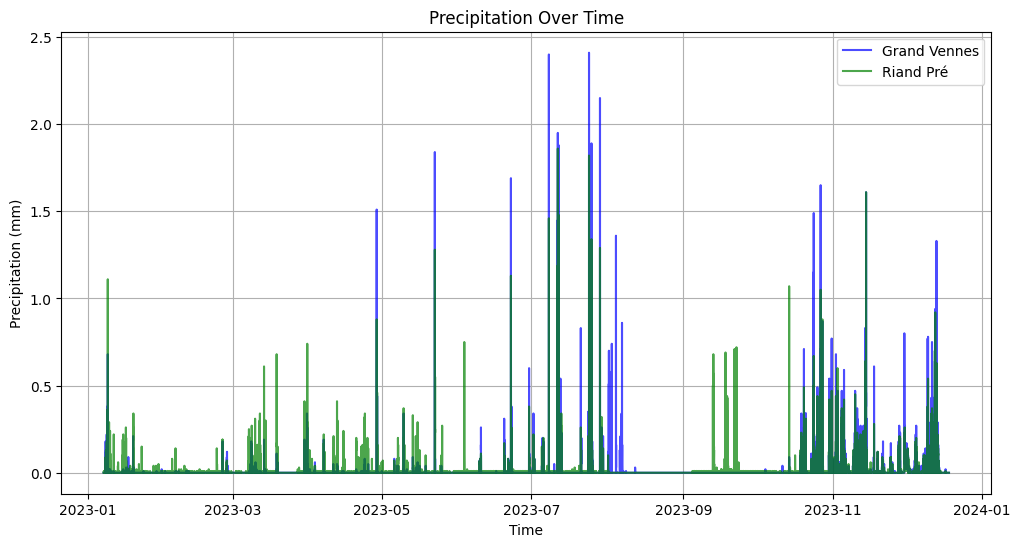

In [ ]:
#Finding the common time period between the two datasets
start_time = max(grandvennes.index.min(), riandpre.index.min())
end_time = min(grandvennes.index.max(), riandpre.index.max())

# Filtering both datasets to the common time period
grandvennes_filtered = grandvennes.loc[start_time:end_time]
riandpre_filtered = riandpre.loc[start_time:end_time]

# Converting precipitation from drops to mm ( 1 drop = 0.01 mm)
grandvennes_filtered['Precipitation_mm'] = grandvennes_filtered['Precipitation'] * 0.01
riandpre_filtered['Precipitation_mm'] = riandpre_filtered['Precipitation'] * 0.01

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(grandvennes_filtered.index, grandvennes_filtered['Precipitation_mm'], label='Grand Vennes', color='blue', alpha=0.7)
plt.plot(riandpre_filtered.index, riandpre_filtered['Precipitation_mm'], label='Riand Pré', color='green', alpha=0.7)

# Adding labels, title, and legend
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

To work with 2 staitions in a GMM model, the data needs to be aligned and merge in 1 dataset. Here are the steps followed to create this dataset:
- Remove the seconds units to have minute precision
- Aligning both datasets to the period (Both dataset have 3 minutes interval)
- If some time points are still missing from one station, drop them from the analysis
- Merge datasets in 1 dataset for GMM

Normally, sensors are set to measure every three minutes, starting with the full hour, so that stations take measurements at the same minutes for easier analysis.

So, when we remove the seconds, we round up to the previous minute to keep this matching.

We still have a step to align the two datasets, as some sensors are not set to the same minutes and are therefore out of sync.

In [ ]:
# Round down the DateTime to the previous minute (removes seconds, truncating)
grandvennes.index = grandvennes.index.floor('min')  # rounded to the nearest lower minute
riandpre.index = riandpre.index.floor('min')

# Resampling to the closest 3-minute interval and filling missing values with NaN
grandvennes_resampled = grandvennes.resample('3min').mean()
riandpre_resampled = riandpre.resample('3min').mean()

# Align both datasets to the common time period (intersection of their timestamps)
start_time = max(grandvennes_resampled.index.min(), riandpre_resampled.index.min())
end_time = min(grandvennes_resampled.index.max(), riandpre_resampled.index.max())

grandvennes_aligned = grandvennes_resampled.loc[start_time:end_time]
riandpre_aligned = riandpre_resampled.loc[start_time:end_time]

# Drop rows with missing values from both datasets
grandvennes_aligned = grandvennes_aligned.dropna()
riandpre_aligned = riandpre_aligned.dropna()

# Now both datasets are aligned and cleaned. Viewing the cleaned and aligned data
print("Aligned and cleaned Grandvennes data:")
print(grandvennes_aligned.head())

print("Aligned and cleaned Riandpre data:")
print(riandpre_aligned.head())


Aligned and cleaned Grandvennes data:
                     Index  Precipitation
DateTime                                 
2023-01-07 08:27:00    1.0            0.0
2023-01-07 08:30:00    2.0            0.0
2023-01-07 08:33:00    3.0            0.0
2023-01-07 08:36:00    4.0            0.0
2023-01-07 08:39:00    5.0            0.0
Aligned and cleaned Riandpre data:
                       Index  Precipitation
DateTime                                   
2023-01-07 08:27:00  28489.0            0.0
2023-01-07 08:30:00  28490.0            0.0
2023-01-07 08:33:00  28491.0            0.0
2023-01-07 08:36:00  28492.0            0.0
2023-01-07 08:39:00  28493.0            0.0


Here is a visualization of 2 datasets to see what the data looks like

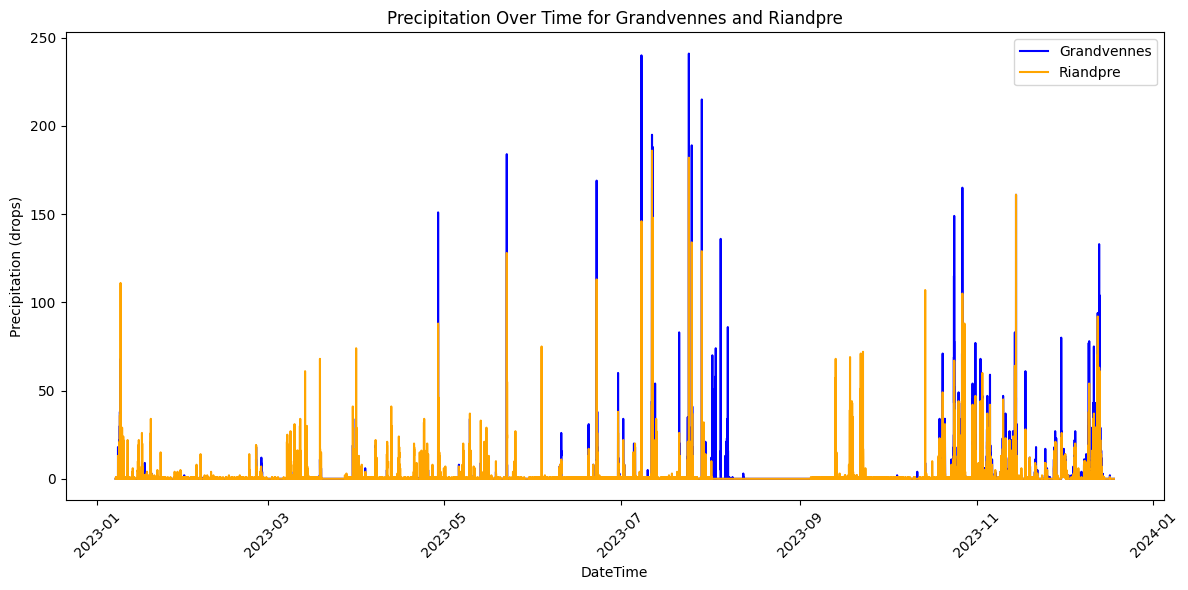

In [ ]:
# Plotting the data for both stations
plt.figure(figsize=(12, 6))

# Plot Grand-Vennes data
plt.plot(grandvennes_aligned.index, grandvennes_aligned['Precipitation'], label='Grandvennes', color='blue')

# Plot Riand-Pré data
plt.plot(riandpre_aligned.index, riandpre_aligned['Precipitation'], label='Riandpre', color='orange')

# Add labels and title
plt.xlabel('DateTime')
plt.ylabel('Precipitation (drops)')
plt.title('Precipitation Over Time for Grandvennes and Riandpre')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Final step to merge the datasets

In [ ]:
# Merge the datasets on the 'DateTime' index
combined_data = pd.merge(grandvennes_aligned[['Precipitation']],
                         riandpre_aligned[['Precipitation']],
                         left_index=True, right_index=True,
                         suffixes=('_Grandvennes', '_Riandpre'))

# Display the first few rows of the combined data
print("Combined Precipitation Data:")
print(combined_data.head())
print(combined_data.shape)

Combined Precipitation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:27:00                        0.0                     0.0
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0
(132231, 2)


# 1.1 Splitting dataset

Split the dataset following this repartition
- First 70% = Training set
- Next 15% = Validation set  
- Last 15% = Testing set

In [ ]:
# Calculate the index for the splits
train_size = int(0.7 * len(combined_data))  # 70% for training
val_size = int(0.15 * len(combined_data))  # 15% for validation
test_size = len(combined_data) - train_size - val_size  # 15% for testing

# Split the data sequentially
train_data = combined_data[:train_size]
val_data = combined_data[train_size:train_size + val_size]
test_data = combined_data[train_size + val_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(train_data.head())

print("\nValidation Data:")
print(val_data.head())

print("\nTest Data:")
print(test_data.head())


Training set size: 92561
Validation set size: 19834
Test set size: 19836

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:27:00                        0.0                     0.0
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0

Validation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-09-26 19:18:00                        0.0                     0.0
2023-09-26 19:21:00                        0.0                     0.0
2023-09-26 19:24:00                        0.0                     0.0
2023-09-26 19:27:00                      

In [ ]:
# Extract X for each dataset
# For training data
X_train = train_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# For validation data
X_valid = val_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# For test data
X_test = test_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# Display the first few rows of the extracted data
print("X_train:")
print(X_train.head())

print("\nX_valid:")
print(X_valid.head())

print("\nX_test:")
print(X_test.head())

X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:27:00                        0.0                     0.0
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0

X_valid:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-09-26 19:18:00                        0.0                     0.0
2023-09-26 19:21:00                        0.0                     0.0
2023-09-26 19:24:00                        0.0                     0.0
2023-09-26 19:27:00                        0.0                     0.0
2023-09-26 19:30:00                        0.0            

# 1.2 Hyperparameter test

**1..2 Evaluation of components range**

Using Bayesian Information Criterion. It is optimal for selecting the optimal model when the number of data points is large

The range tested is from 2 to 10 components

In [ ]:
# Range of components to evaluate
component_range = range(2, 11)  # For component numbers 2, 3, 4, 5, 6, 7, 8, 9, 10

# Store results
models = {}
bic_scores = []
silhouette_scores = []

# Loop through the range of components
for n_components in component_range:
    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)  # Assuming X_train is your data

    # Store the model and metrics
    models[n_components] = gmm
    bic_scores.append(gmm.bic(X_train))

    # Predict cluster labels
    labels = gmm.predict(X_train)

    # Calculate silhouette score
    silhouette = silhouette_score(X_train, labels)
    silhouette_scores.append(silhouette)



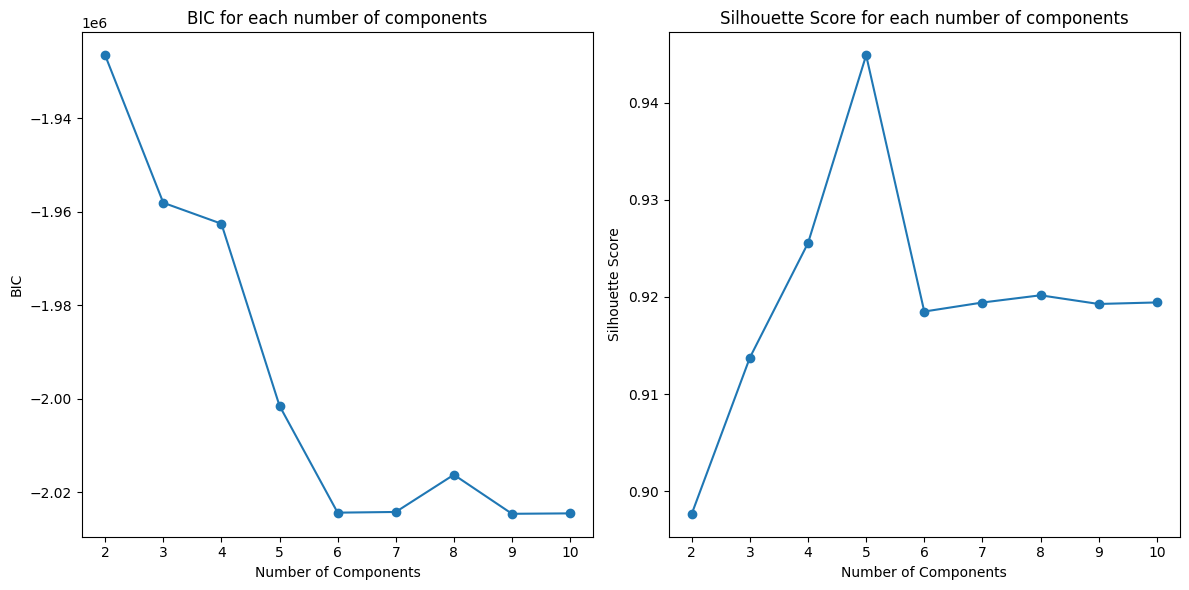

Best number of components: 9 based on BIC


In [ ]:
# Plot BIC, and Silhouette Score for each number of components
plt.figure(figsize=(12, 6))


# Plot BIC
plt.subplot(1, 2, 1)
plt.plot(component_range, bic_scores, marker='o')
plt.title('BIC for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('BIC')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(component_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')

plt.tight_layout()

# Save the figure as a PDF
output_path = "plot_bic_silhouette.pdf"
plt.savefig(output_path, format='pdf')


plt.show()

# Select the best model based on the criteria you prefer (AIC, BIC, or silhouette score)
best_n_components = component_range[np.argmin(bic_scores)]
best_gmm_model = models[best_n_components]
print(f"Best number of components: {best_n_components} based on BIC")


**1.2.3 Combinatiton of hyperparameters**

Trying 4 co-variance option: full, tied, diagonal, spherical with the number of cluster range from 2 to 6.

In [ ]:
#search for best combination of values for both the number of clusters
#and the covariance_type hyperparameter:

min_bic = np.infty

for k in range(1, 7):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X_train).bic(X_train)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

print('best_k')
print(best_k)
print('best_covariance_type')
print(best_covariance_type)



best_k
6
best_covariance_type
diag


# 1.3 Initialization of Gaussian Mixture Model

In [ ]:
# Initialize the Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=5, covariance_type='diag', random_state=42)


In [ ]:
# Fit the GMM model to the training data (X_train)
gmm.fit(X_train)

GaussianMixture(covariance_type='diag', n_components=5, random_state=42)

In [ ]:
# Print the GMM parameters
print("Means of the components:\n", gmm.means_)
print("\nCovariances of the components:\n", gmm.covariances_)
print("\nWeights of the components:\n", gmm.weights_)

# Predict the component labels for each data point
component = gmm.predict(X_train)
proba = gmm.predict_proba(X_train)

# Display the predicted labels
print("Predicted component labels for the data points:\n", labels)
print("Predicted probabilities for each component:\n", proba)

Means of the components:
 [[  0.           0.        ]
 [ 20.51821879  24.26972613]
 [  0.14976542   1.98949622]
 [144.08920093 105.82088681]
 [  3.20019425   7.82895521]]

Covariances of the components:
 [[1.00000000e-06 1.00000000e-06]
 [2.42434319e+02 2.27599267e+02]
 [1.27357297e-01 3.69083893e+00]
 [2.75562292e+03 1.38082625e+03]
 [1.50116146e+01 3.73543584e+01]]

Weights of the components:
 [9.30510652e-01 2.26187043e-03 4.94859588e-02 2.71993308e-04
 1.74695253e-02]
Predicted component labels for the data points:
 [0 0 0 ... 0 0 0]
Predicted probabilities for each component:
 [[9.99999958e-01 1.19071697e-12 4.15500917e-08 6.00633487e-17
  2.48158388e-10]
 [9.99999958e-01 1.19071697e-12 4.15500917e-08 6.00633487e-17
  2.48158388e-10]
 [9.99999958e-01 1.19071697e-12 4.15500917e-08 6.00633487e-17
  2.48158388e-10]
 ...
 [9.99999958e-01 1.19071697e-12 4.15500917e-08 6.00633487e-17
  2.48158388e-10]
 [9.99999958e-01 1.19071697e-12 4.15500917e-08 6.00633487e-17
  2.48158388e-10]
 [9.9

# 1.4 Evaluation of the model

In [ ]:
# Evaluate the log-likelihood of the trained GMM
log_likelihood = gmm.score(X_train)
print(f'Log-Likelihood: {log_likelihood}')


Log-Likelihood: 10.60283552270716


In [ ]:
# Get the labels predicted by the GMM
labels = gmm.predict(X_train)

# Compute silhouette score
silhouette = silhouette_score(X_train, labels)
print(f'Silhouette Score: {silhouette}')


Silhouette Score: 0.9291836528336669


In [ ]:
Valid_score = gmm.score(X_valid)  # Log-likelihood score on test data
Valid_labels = gmm.predict(X_valid)  # Cluster labels for test data
silhouette = silhouette_score(X_valid, Valid_labels)  # Silhouette score

print(f"Log-likelihood on test set: {Valid_score}")
print(f"Silhouette score on test set: {silhouette}")

Log-likelihood on test set: 8.59058354364841
Silhouette score on test set: 0.8645144853905519


In [ ]:
test_score = gmm.score(X_test)  # Log-likelihood score on test data
test_labels = gmm.predict(X_test)  # Cluster labels for test data
silhouette = silhouette_score(X_test, test_labels)  # Silhouette score

print(f"Log-likelihood on test set: {test_score}")
print(f"Silhouette score on test set: {silhouette}")


Log-likelihood on test set: 6.2636739042969705
Silhouette score on test set: 0.781605752625576


In [ ]:
# Calculate BIC for training data
train_bic = gmm.bic(train_data)
print(f"BIC (Train): {train_bic}")

# Similarly, calculate BIC for validation and test data
val_bic = gmm.bic(val_data)
print(f"BIC (Validation): {val_bic}")

test_bic = gmm.bic(test_data)
print(f"BIC (Test): {test_bic}")


BIC (Train): -1961716.041774686
BIC (Validation): -340622.84071570897
BIC (Test): -260507.50552410565


# 1.5 Anomalies identification


In [ ]:
# Compute log-probabilities for data
log_probs = gmm.score_samples(X_train)

In [ ]:
threshold = np.percentile(gmm.score_samples(X_train), 5)  # 5th percentile
anomalies = X_train[log_probs < threshold]
print(anomalies.shape)


(4068, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


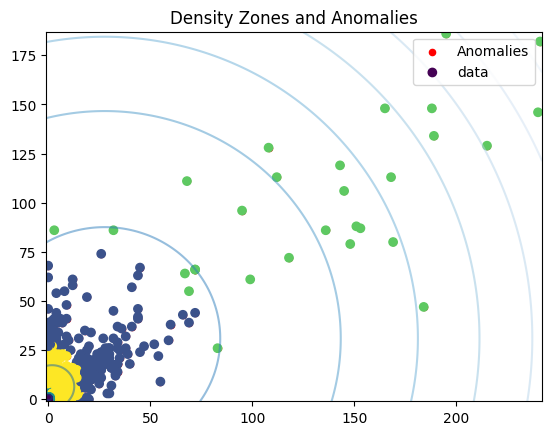

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#Density contours of GMM

x_min, x_max = X_train['Precipitation_Grandvennes'].min() - 1, X_train['Precipitation_Grandvennes'].max() + 1
y_min, y_max = X_train['Precipitation_Riandpre'].min() - 1, X_train['Precipitation_Riandpre'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
Z = gmm.score_samples(grid_points)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=10, cmap='Blues', alpha=0.5)
plt.scatter(anomalies['Precipitation_Grandvennes'], anomalies['Precipitation_Riandpre'], c="red", s=20, label="Anomalies")
plt.scatter(X_train['Precipitation_Grandvennes'], X_train['Precipitation_Riandpre'], c=labels, cmap='viridis', label="data")
plt.legend()
plt.title("Density Zones and Anomalies")

# Save the figure as a PDF
output_path2 = "anomalies.pdf"
plt.savefig(output_path2, format='pdf')

plt.show()




# 1.6 Visualization

This part is a try but I do not have analysed it yet and would probably be modified / remanied.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


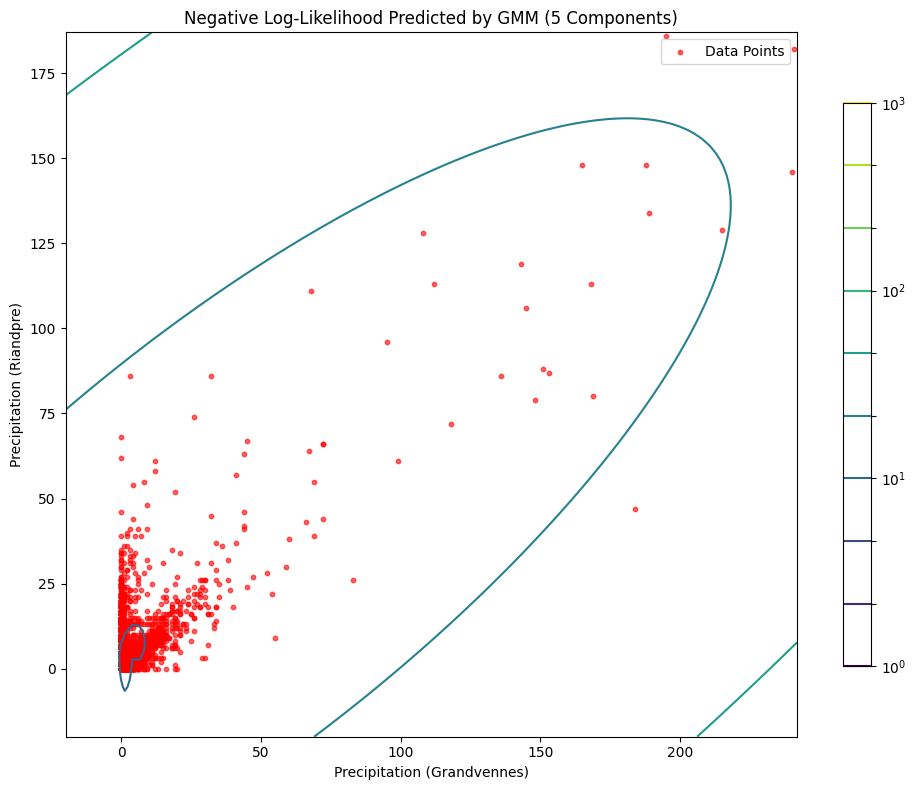

In [ ]:

# Define grid limits based on your dataset
x = np.linspace(-20, X_train['Precipitation_Grandvennes'].max() + 1, 100)
y = np.linspace(-20, X_train['Precipitation_Riandpre'].max() + 1, 100)

# Create a grid for plotting
X, Y = np.meshgrid(x, y)
grid_points = np.array([X.ravel(), Y.ravel()]).T

# Compute negative log-likelihood (density estimation) for the grid points
Z = -gmm.score_samples(grid_points)
Z = Z.reshape(X.shape)

# Plot the negative log-likelihood as a contour plot
plt.figure(figsize=(10, 8))
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10), cmap='viridis')
CB = plt.colorbar(CS, shrink=0.8, extend="both")

# Scatter plot of the actual data points
plt.scatter(X_train['Precipitation_Grandvennes'], X_train['Precipitation_Riandpre'], s=10, c='blue', alpha=0.6, label='Data Points')

# Plot formatting
plt.title("Negative Log-Likelihood Predicted by GMM (5 Components)")
plt.xlabel("Precipitation (Grandvennes)")
plt.ylabel("Precipitation (Riandpre)")
plt.legend()
plt.tight_layout()
plt.show()

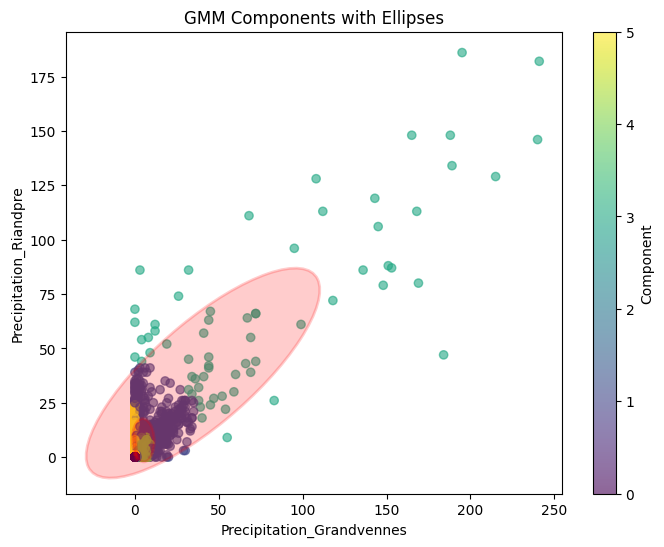

In [ ]:
# Function to plot the Gaussian components as ellipses
def plot_gmm_ellipses(gmm, ax, n_components=5):
    for i in range(n_components):
        # Get the mean and covariance of the component
        mean = gmm.means_[i]
        covar = gmm.covariances_[i]

        # Create an ellipse representing the Gaussian component
        v, w = np.linalg.eigh(covar)  # Eigenvalues and eigenvectors
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)  # Scale the eigenvalues
        u = w[0] / np.linalg.norm(w[0])  # Get the first eigenvector (direction)

        # Plot the ellipse
        angle = np.arctan(u[1] / u[0])  # Angle of the ellipse
        angle = 180.0 * angle / np.pi  # Convert angle to degrees
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=angle,
                                              color='red', alpha=0.2, linewidth=2)
        ax.add_patch(ell)

# Plot the data points and GMM ellipses
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X_train['Precipitation_Grandvennes'], X_train['Precipitation_Riandpre'], c=labels, cmap='viridis', marker='o', alpha=0.6)

# Plot the Gaussian ellipses
plot_gmm_ellipses(gmm, ax)

# Title and labels
plt.title('GMM Components with Ellipses')
plt.xlabel('Precipitation_Grandvennes')
plt.ylabel('Precipitation_Riandpre')
plt.colorbar(scatter, label='Component')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


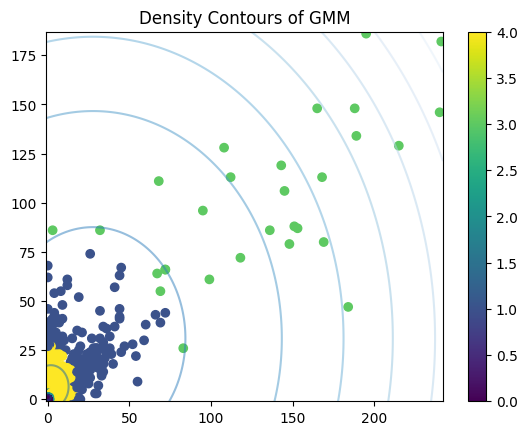

In [ ]:
#Density contours of GMM

x_min, x_max = X_train['Precipitation_Grandvennes'].min() - 1, X_train['Precipitation_Grandvennes'].max() + 1
y_min, y_max = X_train['Precipitation_Riandpre'].min() - 1, X_train['Precipitation_Riandpre'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
Z = gmm.score_samples(grid_points)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=10, cmap='Blues', alpha=0.5)
plt.scatter(X_train['Precipitation_Grandvennes'], X_train['Precipitation_Riandpre'], c=labels, cmap='viridis')
plt.colorbar()
plt.title('Density Contours of GMM')
plt.show()


<ipython-input-64-533ae83a586e>:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[labels == i]['Precipitation_Grandvennes'], label=f'Component {i+1}')
<ipython-input-64-533ae83a586e>:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[labels == i]['Precipitation_Grandvennes'], label=f'Component {i+1}')


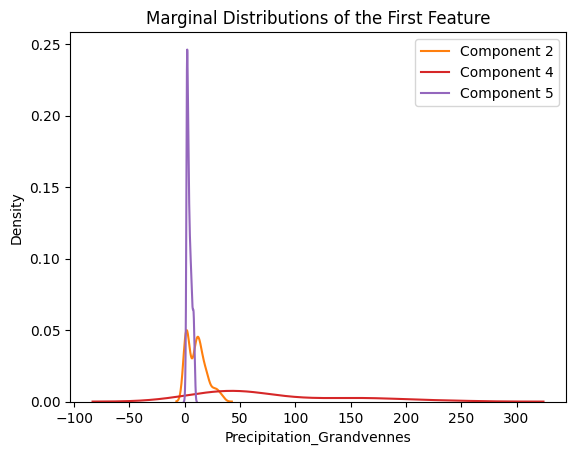

In [ ]:
import seaborn as sns
for i in range(gmm.n_components):
    sns.kdeplot(X_train[labels == i]['Precipitation_Grandvennes'], label=f'Component {i+1}')
plt.title('Marginal Distributions of the First Feature')
plt.legend()
plt.show()


# 2. Complex GMM with 5 stations

Complete the same process than with 2 station but with 5 stations


In [ ]:

# Round down the DateTime to the previous minute (removes seconds, truncating)
grandvennes.index = grandvennes.index.floor('min')  # rounded to the nearest lower minute
riandpre.index = riandpre.index.floor('min')
bethusy.index = bethusy.index.floor('min')
boisgentils.index = boisgentils.index.floor('min')
chandieu.index = chandieu.index.floor('min')
elysee.index = elysee.index.floor('min')
lexplore.index = lexplore.index.floor('min')
pontaise.index = pontaise.index.floor('min')
rouvraie.index = rouvraie.index.floor('min')
vclb.index = vclb.index.floor('min')
geopolis.index = geopolis.index.floor('min')

# Resample both datasets to ensure they have data every 3 minutes (if necessary)
# Resampling to the closest 3-minute interval and filling missing values with NaN
grandvennes_resampled = grandvennes.resample('3min').mean()
riandpre_resampled = riandpre.resample('3min').mean()
bethusy_resampled = bethusy.resample('3min').mean()
boisgentils_resampled = boisgentils.resample('3min').mean()
chandieu_resampled = chandieu.resample('3min').mean()
elysee_resampled = elysee.resample('3min').mean()
lexplore_resampled = lexplore.resample('3min').mean()
pontaise_resampled = pontaise.resample('3min').mean()
rouvraie_resampled = rouvraie.resample('3min').mean()
vclb_resampled = vclb.resample('3min').mean()
geopolis_resampled = geopolis.resample('3min').mean()


# Align both datasets to the common time period (intersection of their timestamps)
start_time = max(grandvennes_resampled.index.min(), riandpre_resampled.index.min(),bethusy_resampled.index.min(),
                 boisgentils_resampled.index.min(),chandieu_resampled.index.min(),elysee_resampled.index.min(), lexplore_resampled.index.min(),
                 pontaise_resampled.index.min(),rouvraie_resampled.index.min(),vclb_resampled.index.min(),geopolis_resampled.index.min())


end_time = min(grandvennes_resampled.index.max(), riandpre_resampled.index.max(), bethusy_resampled.index.max(),
               boisgentils_resampled.index.max(),chandieu_resampled.index.max(),elysee_resampled.index.max(),lexplore_resampled.index.max(),
               pontaise_resampled.index.max(),rouvraie_resampled.index.max(),vclb_resampled.index.max(),geopolis_resampled.index.max())

grandvennes_aligned = grandvennes_resampled.loc[start_time:end_time]
riandpre_aligned = riandpre_resampled.loc[start_time:end_time]
bethusy_aligned = bethusy_resampled.loc[start_time:end_time]
boisgentils_aligned = boisgentils_resampled.loc[start_time:end_time]
chandieu_aligned = chandieu_resampled.loc[start_time:end_time]
elysee_aligned = elysee_resampled.loc[start_time:end_time]
lexplore_aligned = lexplore_resampled.loc[start_time:end_time]
pontaise_aligned = pontaise_resampled.loc[start_time:end_time]
rouvraie_aligned = rouvraie_resampled.loc[start_time:end_time]
vclb_aligned = vclb_resampled.loc[start_time:end_time]
geopolis_aligned = geopolis_resampled.loc[start_time:end_time]

# Drop rows with missing values from both datasets
grandvennes_aligned = grandvennes_aligned.dropna()
riandpre_aligned = riandpre_aligned.dropna()
bethusy_aligned = bethusy_aligned.dropna()
boisgentils_aligned = boisgentils_aligned.dropna()
chandieu_aligned = chandieu_aligned.dropna()
elysee_aligned = elysee_aligned.dropna()
lexplore_aligned = lexplore_aligned.dropna()
pontaise_aligned = pontaise_aligned.dropna()
rouvraie_aligned = rouvraie_aligned.dropna()
vclb_aligned = vclb_aligned.dropna()

# Now both datasets are aligned and cleaned. Viewing the cleaned and aligned data
print("Aligned and cleaned Grandvennes data:")
print(grandvennes_aligned.head())

print("Aligned and cleaned Riandpre data:")
print(riandpre_aligned.head())

print("Aligned and cleaned Bethusy data:")
print(bethusy_aligned.head())

print("Aligned and cleaned Boisgentils data:")
print(boisgentils_aligned.head())

print("Aligned and cleaned Chandieu data:")
print(chandieu_aligned.head())

print("Aligned and cleaned Elysee data:")
print(elysee_aligned.head())

print("Aligned and cleaned Lexplore data:")
print(lexplore_aligned.head())

print("Aligned and cleaned Pontaise data:")
print(pontaise_aligned.head())

print("Aligned and cleaned Rouvraie data:")
print(rouvraie_aligned.head())

print("Aligned and cleaned Vclb data:")
print(vclb_aligned.head())


Aligned and cleaned Grandvennes data:
                     Index  Precipitation
DateTime                                 
2023-01-07 08:27:00    1.0            0.0
2023-01-07 08:30:00    2.0            0.0
2023-01-07 08:33:00    3.0            0.0
2023-01-07 08:36:00    4.0            0.0
2023-01-07 08:39:00    5.0            0.0
Aligned and cleaned Riandpre data:
                       Index  Precipitation
DateTime                                   
2023-01-07 08:27:00  28489.0            0.0
2023-01-07 08:30:00  28490.0            0.0
2023-01-07 08:33:00  28491.0            0.0
2023-01-07 08:36:00  28492.0            0.0
2023-01-07 08:39:00  28493.0            0.0
Aligned and cleaned Bethusy data:
                       Index  Precipitation
DateTime                                   
2023-01-07 08:27:00  18409.0            0.0
2023-01-07 08:30:00  18410.0            0.0
2023-01-07 08:33:00  18411.0            0.0
2023-01-07 08:36:00  18412.0            0.0
2023-01-07 08:39:00  18413.

In [ ]:
# Merge the datasets on the 'DateTime' index
combined_data = pd.concat(
    [
        grandvennes_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Grandvennes'}),
        riandpre_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Riandpre'}),
        bethusy_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Bethusy'}),
        boisgentils_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Boisgentils'}),
        chandieu_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Chandieu'}),
        elysee_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Elysee'}),
        lexplore_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Lexplore'}),
        pontaise_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Pontaise'}),
        rouvraie_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Rouvraie'}),
        vclb_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_VCLB'}),
    ],
    axis=1,
    join='inner'  # Ensures alignment on shared indices only
)

# Display the first few rows of the combined data
print("Combined Precipitation Data:")
print(combined_data.head())
print(combined_data.shape)



Combined Precipitation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-07 08:27:00                        0.0                     0.0   
2023-01-07 08:30:00                        0.0                     0.0   
2023-01-07 08:33:00                        0.0                     0.0   
2023-01-07 08:36:00                        0.0                     0.0   
2023-01-07 08:39:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-07 08:27:00                    0.0                        0.0   
2023-01-07 08:30:00                    0.0                        0.0   
2023-01-07 08:33:00                    0.0                        0.0   
2023-01-07 08:36:00                    0.0                        0.0   
2023-01-07 08:

In [ ]:
# Calculate the index for the splits
train_size = int(0.7 * len(combined_data))  # 70% for training
val_size = int(0.15 * len(combined_data))  # 15% for validation
test_size = len(combined_data) - train_size - val_size  # 15% for testing

# Split the data sequentially
train_data = combined_data[:train_size]
val_data = combined_data[train_size:train_size + val_size]
test_data = combined_data[train_size + val_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(train_data.head())

print("\nValidation Data:")
print(val_data.head())

print("\nTest Data:")
print(test_data.head())


Training set size: 49851
Validation set size: 10682
Test set size: 10684

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-07 08:27:00                        0.0                     0.0   
2023-01-07 08:30:00                        0.0                     0.0   
2023-01-07 08:33:00                        0.0                     0.0   
2023-01-07 08:36:00                        0.0                     0.0   
2023-01-07 08:39:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-07 08:27:00                    0.0                        0.0   
2023-01-07 08:30:00                    0.0                        0.0   
2023-01-07 08:33:00                    0.0                        0.0   
2023-01-07 08:36:00        

In [ ]:
# Extract X for each dataset
# For training data
X_train = train_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# For validation data
X_valid = val_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# For test data
X_test = test_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre']]  # Features (precipitation from both stations)

# Display the first few rows of the extracted data
print("X_train:")
print(X_train.head())

print("\nX_valid:")
print(X_valid.head())

print("\nX_test:")
print(X_test.head())

X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-01-07 08:27:00                        0.0                     0.0
2023-01-07 08:30:00                        0.0                     0.0
2023-01-07 08:33:00                        0.0                     0.0
2023-01-07 08:36:00                        0.0                     0.0
2023-01-07 08:39:00                        0.0                     0.0

X_valid:
                     Precipitation_Grandvennes  Precipitation_Riandpre
DateTime                                                              
2023-10-04 15:45:00                        0.0                     0.0
2023-10-04 15:48:00                        0.0                     0.0
2023-10-04 15:51:00                        0.0                     0.0
2023-10-04 15:54:00                        0.0                     0.0
2023-10-04 15:57:00                        0.0            

In [ ]:
# Range of components to evaluate
component_range = range(2, 10)  # For component numbers 2, 3, 4, 5, 6, 7, 8, 9

# Store results
models = {}
bic_scores = []
silhouette_scores = []

# Loop through the range of components
for n_components in component_range:
    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)  # Assuming X_train is your data

    # Store the model and metrics
    models[n_components] = gmm
    bic_scores.append(gmm.bic(X_train))

    # Predict cluster labels
    labels = gmm.predict(X_train)

    # Calculate silhouette score
    silhouette = silhouette_score(X_train, labels)
    silhouette_scores.append(silhouette)



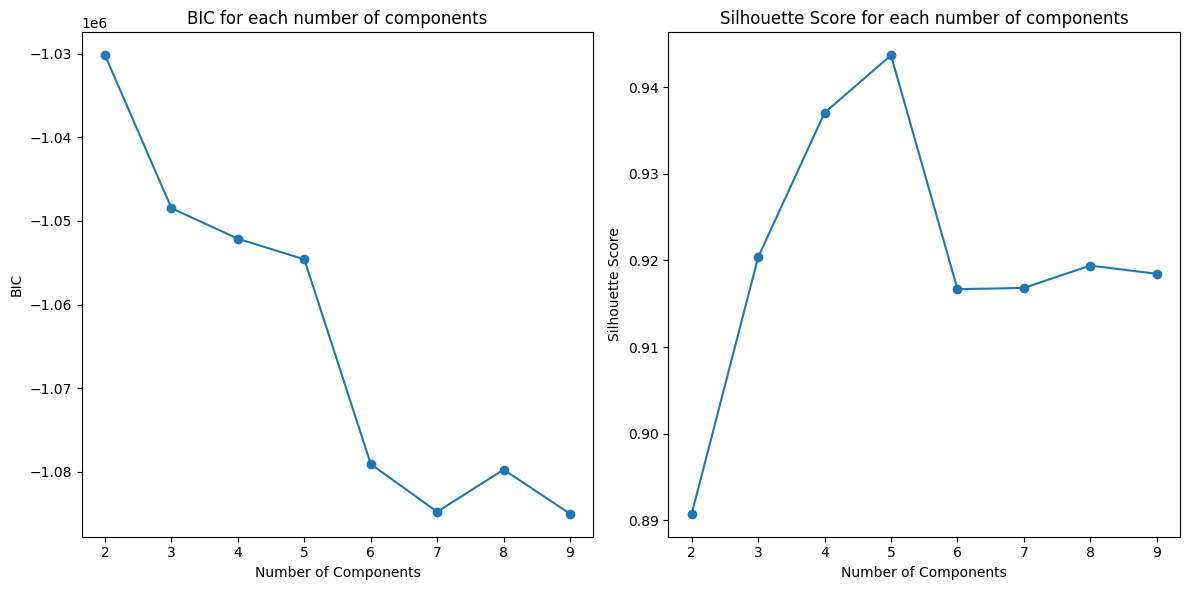

Best number of components: 9 based on BIC


In [ ]:
# Plot BIC, and Silhouette Score for each number of components
plt.figure(figsize=(12, 6))


# Plot BIC
plt.subplot(1, 2, 1)
plt.plot(component_range, bic_scores, marker='o')
plt.title('BIC for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('BIC')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(component_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')

plt.tight_layout()

# Save the figure as a PDF
output_path = "plot_bic_silhouette_full.pdf"
plt.savefig(output_path, format='pdf')


plt.show()

# Select the best model based on the criteria you prefer (AIC, BIC, or silhouette score)
best_n_components = component_range[np.argmin(bic_scores)]
best_gmm_model = models[best_n_components]
print(f"Best number of components: {best_n_components} based on BIC")


In [ ]:
#search for best combination of values for both the number of clusters
#and the covariance_type hyperparameter:

min_bic = np.infty

for k in range(1, 7):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X_train).bic(X_train)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

print('best_k')
print(best_k)
print('best_covariance_type')
print(best_covariance_type)



best_k
6
best_covariance_type
full
